# Longitudinal QuasiCopula GWAS with Mixed Marginals

Here we adopt the variance component model framework

$$\mathbf{\Gamma}_i(\mathbf{\theta}) = \sum_{k=1}^m \theta_k\mathbf{V}_{ik}, \quad \theta_k \ge 0$$

In [1]:
using Revise
using DataFrames, Random, GLM, QuasiCopula
using ForwardDiff, Test, LinearAlgebra
using LinearAlgebra: BlasReal, copytri!
using ToeplitzMatrices
using BenchmarkTools
using SnpArrays
using MendelPlots

BLAS.set_num_threads(1)
Threads.nthreads()

function simulate_random_snparray(s::Union{String, UndefInitializer}, n::Int64,
    p::Int64; mafs::Vector{Float64}=zeros(Float64, p), min_ma::Int = 5)

    #first simulate a random {0, 1, 2} matrix with each SNP drawn from Binomial(2, r[i])
    A1 = BitArray(undef, n, p) 
    A2 = BitArray(undef, n, p) 
    for j in 1:p
        minor_alleles = 0
        maf = 0
        while minor_alleles <= min_ma
            maf = 0.5rand()
            for i in 1:n
                A1[i, j] = rand(Bernoulli(maf))
                A2[i, j] = rand(Bernoulli(maf))
            end
            minor_alleles = sum(view(A1, :, j)) + sum(view(A2, :, j))
        end
        mafs[j] = maf
    end

    #fill the SnpArray with the corresponding x_tmp entry
    return _make_snparray(s, A1, A2)
end

function _make_snparray(s::Union{String, UndefInitializer}, A1::BitArray, A2::BitArray)
    n, p = size(A1)
    x = SnpArray(s, n, p)
    for i in 1:(n*p)
        c = A1[i] + A2[i]
        if c == 0
            x[i] = 0x00
        elseif c == 1
            x[i] = 0x02
        elseif c == 2
            x[i] = 0x03
        else
            throw(MissingException("matrix shouldn't have missing values!"))
        end
    end
    return x
end


┌ Info: Precompiling QuasiCopula [c47b6ae2-b804-4668-9957-eb588c99ffbc]
└ @ Base loading.jl:1423
  ** incremental compilation may be fatally broken for this module **



_make_snparray (generic function with 1 method)

## Simulate data

In [64]:
function simulate_VC_longitudinal(;
    n = 1000, # sample size
    d = 5, # number of observations per sample
    p = 3, # number of nongenetic covariates, including intercept
    m = 2, # number of variance components
    q = 1000, # number of SNPs
    k = 10, # number of causal SNPs
    seed = 2022,
    y_distribution = Bernoulli,
    T = Float64,
    )
    m == 1 || m == 2 || error("m (number of VC) must be 1 or 2")
    
    # non-genetic effect sizes
    Random.seed!(seed)
    βtrue = rand(Uniform(-0.2, 0.2), p)
    dist = y_distribution()
    link = canonicallink(dist)
    Dist = typeof(dist)
    Link = typeof(link)

    # variance components
    θtrue = fill(0.1, m)
    V1 = ones(d, d)
    V2 = Matrix(I, d, d)
    Γ = m == 1 ? θtrue[1] * V1 : θtrue[1] * V1 + θtrue[2] * V2

    # simulate design matrices
    Random.seed!(seed)
    X_full = [hcat(ones(d), randn(d, p - 1)) for i in 1:n]

    # simulate random SnpArray with 100 SNPs and randomly choose k SNPs to be causal
    Random.seed!(2022)
    G = simulate_random_snparray(undef, n, q)
    Gfloat = convert(Matrix{T}, G, center=true, scale=false)
    γtrue = zeros(q)
    γtrue[1:k] .= rand([-0.2, 0.2], k)
    shuffle!(γtrue)
    η_G = Gfloat * γtrue

    # simulate phenotypes
    if y_distribution == Normal
        τtrue = 10.0
        σ2 = inv(τtrue)
        σ = sqrt(σ2)
        obs = Vector{GaussianCopulaVCObs{T}}(undef, n)
        for i in 1:n
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            vecd = Vector{ContinuousUnivariateDistribution}(undef, d)
            for i in 1:d
                vecd[i] = y_distribution(μ[i], σ)
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, d)
            res = Vector{T}(undef, d)
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GaussianCopulaVCObs(y, X, V)
        end
        qc_model = GaussianCopulaVCModel(obs)
    else
        obs = Vector{GLMCopulaVCObs{T, Dist, Link}}(undef, n)
        for i in 1:n
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            vecd = Vector{DiscreteUnivariateDistribution}(undef, d)
            for i in 1:d
                vecd[i] = y_distribution(μ[i])
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, d)
            res = Vector{T}(undef, d)
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GLMCopulaVCObs(y, X, V, dist, link)
        end
        qc_model = GLMCopulaVCModel(obs)
    end
    return qc_model, Γ, G, βtrue, θtrue, γtrue
end

k = 0 # number of causal SNPs

qc_model, Γ, G, βtrue, θtrue, γtrue = simulate_VC_longitudinal(
    n = 5000, # sample size
    d = 5, # number of observations per sample
    p = 3, # number of fixed effects, including intercept
    m = 1, # number of variance components
    q = 1000, # number of SNPs
    k = k, # number of causal SNPs
    seed = 2022,
    y_distribution = Poisson,
    T = Float64,
)

@show qc_model;

qc_model = Quasi-Copula Variance Component Model
  * base distribution: Poisson
  * link function: LogLink
  * number of clusters: 5000
  * cluster size min, max: 5, 5
  * number of variance components: 1
  * number of fixed effects: 3



## Fit Null model

In [65]:
@time optm = QuasiCopula.fit!(qc_model,
    Ipopt.IpoptSolver(
        print_level = 5, 
        tol = 10^-6, 
        max_iter = 1000,
        accept_after_max_steps = 4,
        warm_start_init_point="yes", 
        limited_memory_max_history = 6, # default value
        hessian_approximation = "limited-memory",
#         derivative_test="second-order"
    )
);

initializing β using Newton's Algorithm under Independence Assumption
gcm.β = [-0.10475740605685649, 0.16112548333125815, 0.003586381225925596]
initializing variance components using MM-Algorithm
gcm.θ = [0.08968131835408427]
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        4
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:

In [66]:
@show βtrue
@show qc_model.β
@show qc_model.∇β

@show θtrue
@show qc_model.θ
@show qc_model.∇θ;

βtrue = [-0.15724541848225881, 0.1622105756389522, 0.008250501994707893]
qc_model.β = [-0.15389620939013315, 0.16858516428854245, 0.003914811907814301]
qc_model.∇β = [-5.171831114481051e-7, 2.054137997475891e-7, -7.279939007176495e-8]
θtrue = [0.1]
qc_model.θ = [0.10270007729386353]
qc_model.∇θ = [1.8687455760613148e-7]


## Score test



Why are p-values deflated? 
+ Check if $\nabla res(\beta)$ correct via forwardDiff.jl **(done)**
+ Check if terms (e.g. $\nabla res*\Gamma*res$) match corresponding terms in loglikelihood calculation in GLM_VC.jl  **(done)**
+ Try adding another term to the Hessian approximation **(done)**
+ Is degree of freedom 1??
+ Check Hessian terms with SNP are correct mathematically
+ Add more terms of W, Q 

In [195]:
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G, num_Hessian_terms=2)

 50.687975 seconds (1.04 G allocations: 29.791 GiB, 6.00% gc time, 1.03% compilation time)


1000-element Vector{Float64}:
 0.9999999989212872
 0.39468053219955496
 0.15524526927666873
 0.1414603039578431
 0.9999999988070686
 0.9999999997659612
 0.3291143526118666
 0.9999999982384455
 0.6300322278536103
 0.2254551527596412
 0.9234113925521524
 0.3525152127618113
 0.683076321947017
 ⋮
 0.48201879325325275
 0.046928684749470095
 0.019925115854505095
 0.519930407055673
 0.15190526906300786
 0.8845417925746385
 0.5925480208744327
 0.913570477044532
 0.6095074919411411
 0.9999999997922585
 0.702642787861904
 0.9669501439463286

In [196]:
correct_snps = findall(!iszero, γtrue)
signif_snps = findall(x -> x < 0.05/length(pvals), pvals)
power = length(correct_snps ∩ signif_snps) / max(1, length(correct_snps))

@show length(signif_snps)
@show power

length(signif_snps) = 0
power = 0.0


0.0

In [197]:
# pvalues of truly causal SNPs
pvals[correct_snps] |> sort

Float64[]

In [198]:
# pvalues of all SNPs sorted by significance
sort(pvals)

1000-element Vector{Float64}:
 9.31185352086859e-5
 0.00014145799846096375
 0.0016592508225119942
 0.0019246889378784456
 0.0019413888665436893
 0.0038898889465734674
 0.005972365314391423
 0.0077405232750701065
 0.008605735438747316
 0.009228893551928343
 0.009478210051682034
 0.012632236606407134
 0.013654413360932286
 ⋮
 0.9999999997498416
 0.9999999997659612
 0.9999999997701988
 0.9999999997735711
 0.999999999777892
 0.9999999997922585
 0.999999999797463
 0.9999999998091319
 0.9999999998380114
 0.9999999998789
 0.9999999998852344
 0.9999999999124911

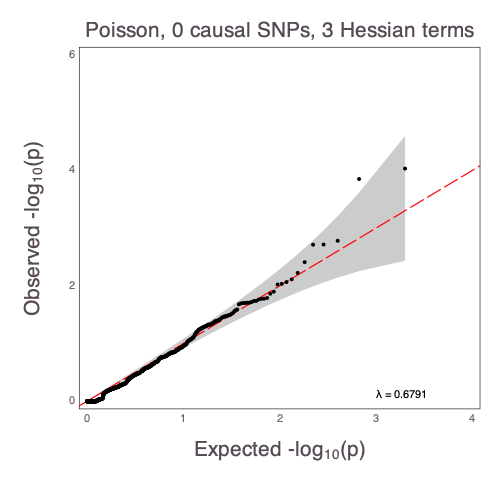

In [199]:
# autodiff R
qq(pvals, dpi=100, titles="Poisson, $k causal SNPs, 3 Hessian terms")
display("image/png", read("qqplot.png"))

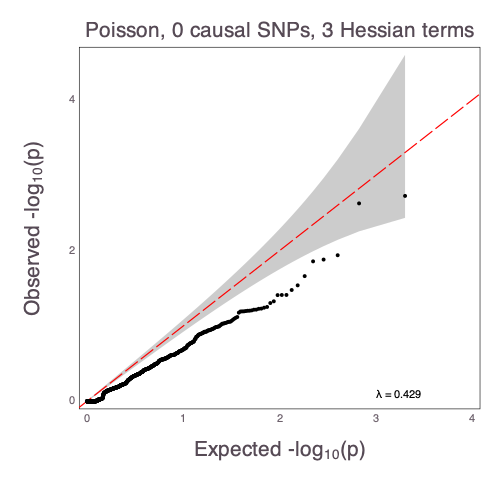

In [94]:
# autodiff R
qq(pvals, dpi=100, titles="Poisson, $k causal SNPs, 3 Hessian terms")
display("image/png", read("qqplot.png"))

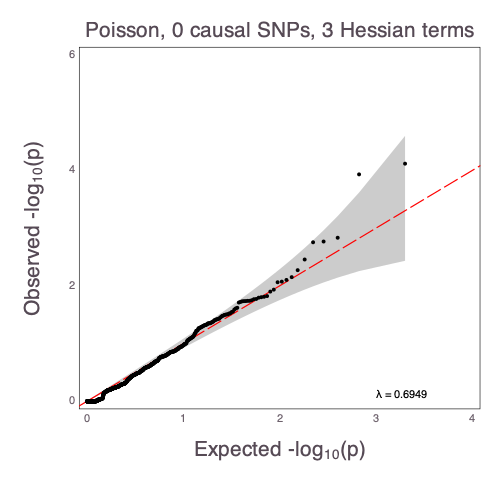

In [99]:
# autodiff R, Wtail2 and Qtrail2
qq(pvals, dpi=100, titles="Poisson, $k causal SNPs, 3 Hessian terms")
display("image/png", read("qqplot.png"))

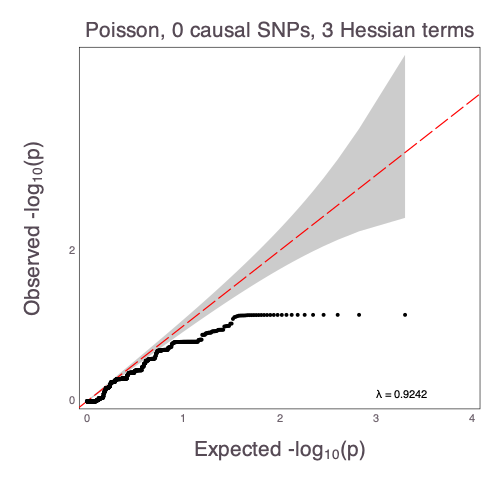

In [76]:
# autodiff R/W/Q
qq(pvals, dpi=100, titles="Poisson, $k causal SNPs, 3 Hessian terms")
display("image/png", read("qqplot.png"))

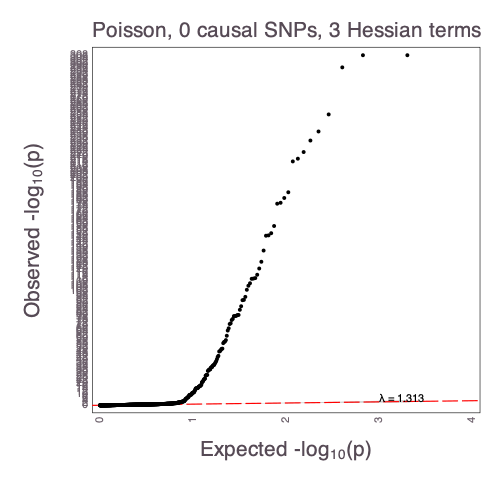

In [71]:
# autodiff W and Q
qq(pvals, dpi=100, titles="Poisson, $k causal SNPs, 3 Hessian terms")
display("image/png", read("qqplot.png"))

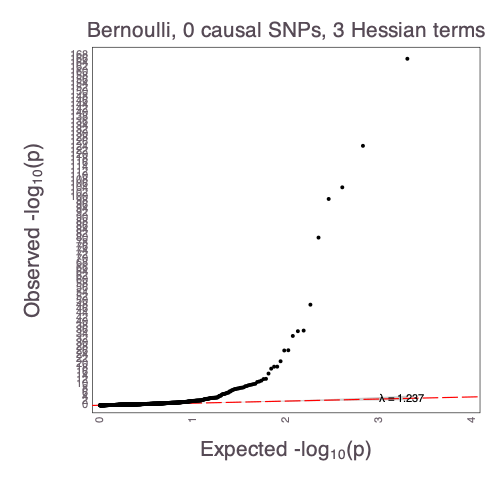

In [56]:
# Wtrail2 + autodiff Q
qq(pvals, dpi=100, titles="Bernoulli, $k causal SNPs, 3 Hessian terms")
display("image/png", read("qqplot.png"))

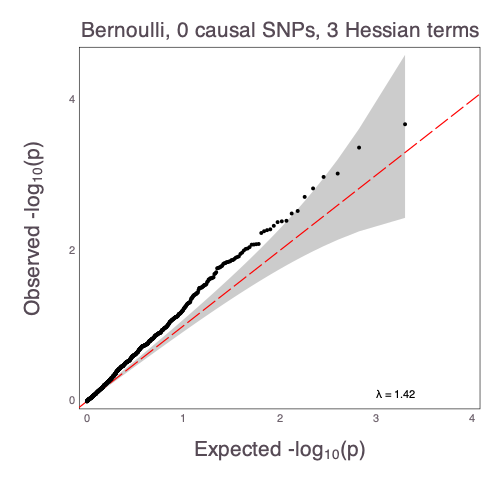

In [28]:
# only Qtrail2
qq(pvals, dpi=100, titles="Bernoulli, $k causal SNPs, 3 Hessian terms")
display("image/png", read("qqplot.png"))

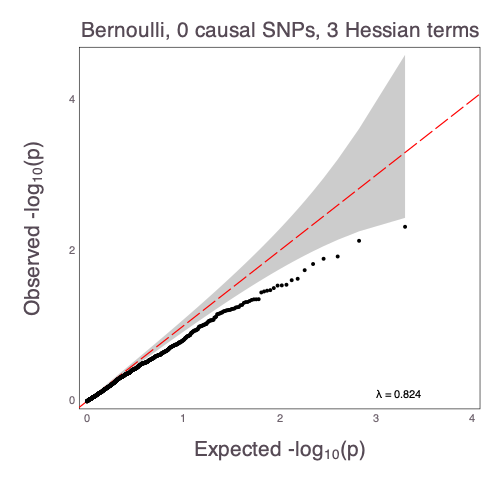

In [33]:
# only Wtrail2
qq(pvals, dpi=100, titles="Bernoulli, $k causal SNPs, 3 Hessian terms")
display("image/png", read("qqplot.png"))

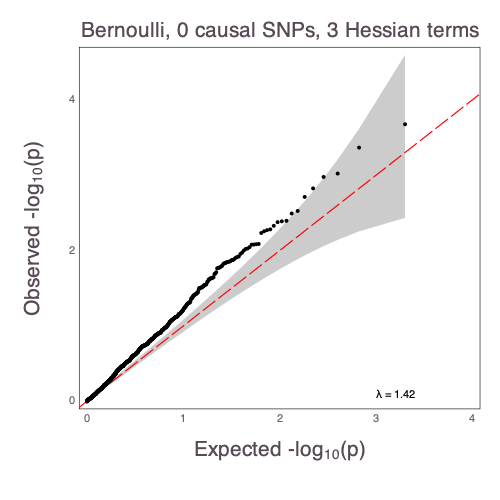

In [38]:
# only Qtrail2 + Wtrail2
qq(pvals, dpi=100, titles="Bernoulli, $k causal SNPs, 3 Hessian terms")
display("image/png", read("qqplot.png"))

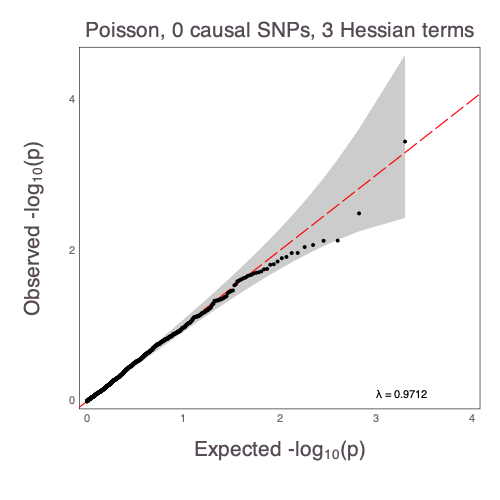

In [20]:
# only Qtrail2
qq(pvals, dpi=100, titles="Poisson, $k causal SNPs, 3 Hessian terms")
display("image/png", read("qqplot.png"))

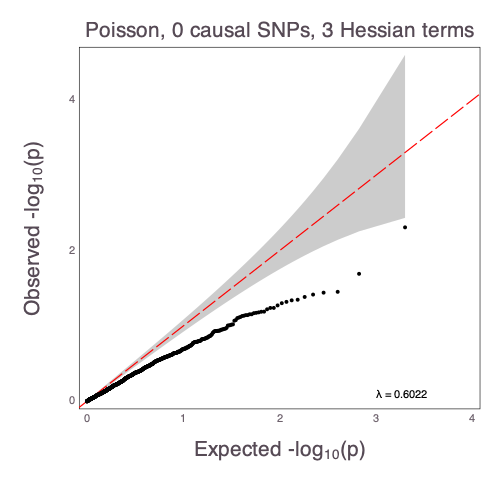

In [15]:
# only Wtrail2
qq(pvals, dpi=100, titles="Poisson, $k causal SNPs, 3 Hessian terms")
display("image/png", read("qqplot.png"))

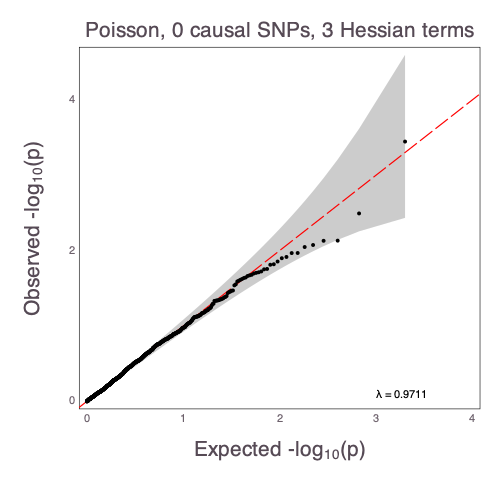

In [10]:
# Qtail2 + Wtrail2
qq(pvals, dpi=100, titles="Poisson, $k causal SNPs, 3 Hessian terms")
display("image/png", read("qqplot.png"))

## QQ Plots

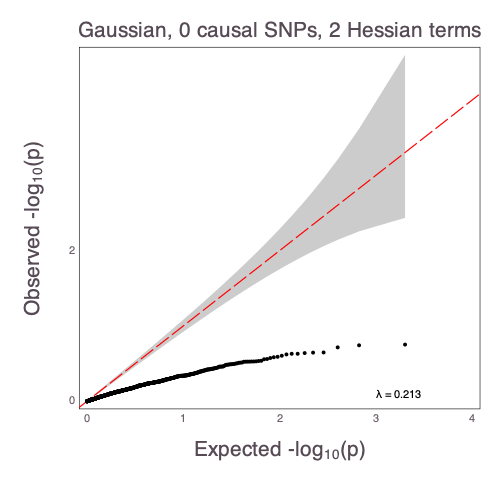

In [219]:
qq(pvals, dpi=100, titles="Gaussian, $k causal SNPs, 2 Hessian terms")
display("image/png", read("qqplot.png"))

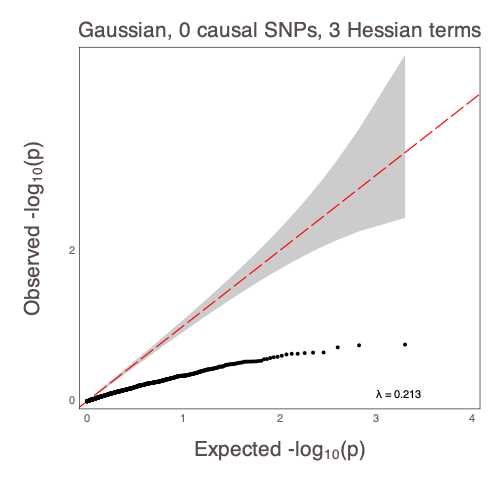

In [197]:
qq(pvals, dpi=100, titles="Gaussian, $k causal SNPs, 3 Hessian terms")
display("image/png", read("qqplot.png"))

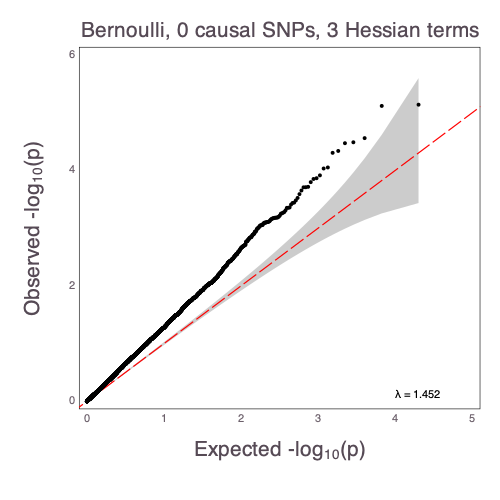

In [141]:
qq(pvals, dpi=100, titles="Bernoulli, $k causal SNPs, 3 Hessian terms")
display("image/png", read("qqplot.png"))

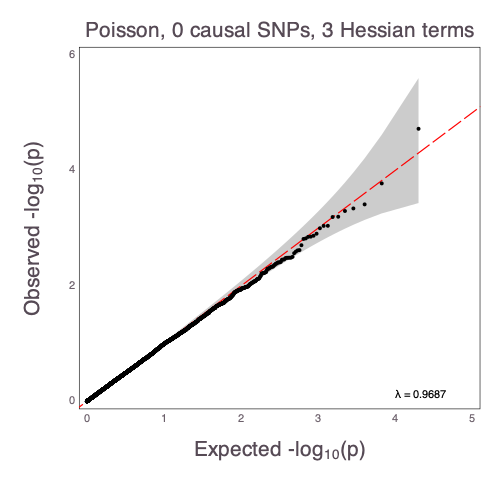

In [157]:
qq(pvals, dpi=100, titles="Poisson, $k causal SNPs, 3 Hessian terms")
display("image/png", read("qqplot.png"))

## QQ Plots (tweaked)

+ I can tweak calculation of $\nabla res(\beta)$ so that the resulting p-values for Normal and Bernoulli base look "correct".
+ This uses the full Hessian to calculate W, Q, R. 
+ For Poisson I haven't found a way to tweak them. 

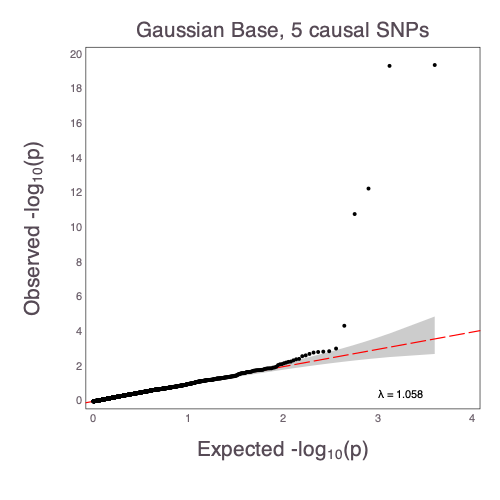

In [320]:
qq(pvals, dpi=100, titles="Gaussian Base, 5 causal SNPs")
display("image/png", read("qqplot.png"))

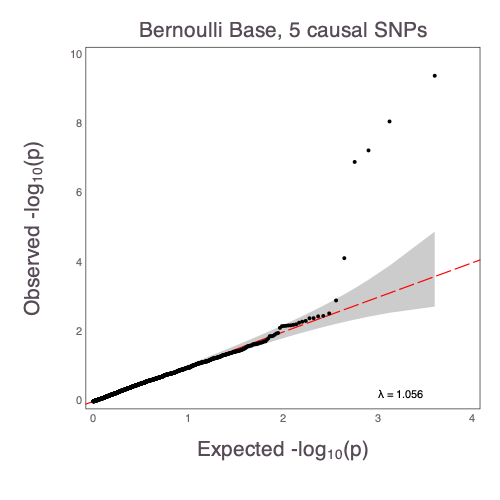

In [301]:
qq(pvals, dpi=100, titles="Bernoulli Base, 5 causal SNPs")
display("image/png", read("qqplot.png"))